In [1]:
import pm4py
# import cortado_core
from pm4py.util import constants, xes_constants, pandas_utils
import pandas as pd
import datetime as dt
import numpy as np
import sklearn
import sys
import stringcase

sys.path.append('../')
%load_ext autoreload
%autoreload 2
import pmxplain

In [2]:
df_l = pd.read_pickle("./data/df_l.pkl")
df_joined = pd.read_pickle("./data/df_joined.pkl")
df_joined['case:concept:name'] = df_joined.index

In [4]:
def get_data_category(series):
    if pd.api.types.is_bool_dtype(series.dtype):
        return 'boolean'
    elif pd.api.types.is_numeric_dtype(series.dtype):
        return 'numeric'
    elif isinstance(series.dtype, pd.CategoricalDtype):
        return 'categorical'
    elif pd.api.types.is_datetime64_any_dtype(series.dtype):
        return 'datetime'
    elif isinstance(series.dtype, pd.PeriodDtype):
        return 'period'
    elif pd.api.types.is_timedelta64_dtype(series.dtype):
        return 'timedelta'
    elif isinstance(series.dtype, pd.IntervalDtype):
        return 'interval'
    elif pd.api.types.is_string_dtype(series.dtype):
        return 'string'
    else:
        return 'other'
  
BIN_TRESHOLD = 0.1
MAX_BINS = 30
# takes the dataframe description and the original dataframe and 
# recommends whether the individual columns must be 
# converted into categorical values for further use
def recommend_binning(df_meta, df):
    bin_it = []
    bin_sizes = []

    for _, row in df_meta.iterrows():
        # Get the fraction of distinct values for the current column
        fraction = row['fraction_of_distinct_values']
        distinct = row['distinct_values']
        # If the fraction of distinct values is less than a certain threshold (e.g., 0.1), 
        # recommend converting the column into categorical values
        if (distinct > 30 or fraction > BIN_TRESHOLD) and row['category'] in ('numeric', 'timedelta', 'datetime'):
            df_meta.at[row.name, 'recommended_conversion'] = 'binning_needed'

              #  Recommend bin size as the square root of the number of distinct values
            bin_sizes.append(int( min(np.sqrt(df[row.name].nunique()), MAX_BINS)))
        else:
            bin_sizes.append(0)

    df_meta['bin_sizes'] = bin_sizes
    return df_meta

def apply_bin_to_column(df, row):
    name = 'bin||'+row.name
    df[name] = pd.cut(df[row.name], row['bin_sizes'],right=True,include_lowest=True,duplicates='drop')
    return name

def add_recommended_bin_columns(df_meta, df):
    new_columns = []
    for _, row in df_meta.iterrows():        
        if row['recommended_conversion'] == 'binning_needed' and row['treat_as'] == ('feature'):
          name = apply_bin_to_column(df, row) 
          df_meta.at[row.name, 'treat_as'] = name
          new_columns.append( name )

    if len(new_columns) > 0:
      added_df = _describe_dataframe(df[new_columns])
      df_meta = pd.concat([df_meta, added_df])
    return df_meta

import re

def convert_to_nice_string(name):
    
    return stringcase.titlecase(name)
    
def recommend_conversion(df_description):
    recommended_conversion = []
    for _, row in df_description.iterrows():
        if row['category'] == 'numeric' and row['has_nan_values']:
            recommended_conversion.append('fill_nan_with_mean_convert_to_int64')
        elif row['category'] == 'numeric' and not row['has_nan_values']:
            recommended_conversion.append('convert_to_int64')
        else:
            recommended_conversion.append('no_conversion_needed')
    df_description['recommended_conversion'] = recommended_conversion
    return df_description

def recommend_treat_as(df_description):
    treat_as = []
    for _, row in df_description.iterrows():
        if row['category'] == 'numeric' and row['has_nan_values']:
            treat_as.append('fill_nan_with_mean_convert_to_int64')
        elif row['category'] == 'numeric' and not row['has_nan_values']:
            treat_as.append('convert_to_int64')
        else:
            treat_as.append('feature')
    df_description['treat_as'] = treat_as
    return df_description

def _describe_dataframe(df):
    description = pd.DataFrame({
        'name': [convert_to_nice_string(col) for col in df.columns],
        'column': df.columns,
        'dtype': df.dtypes.values,
        'category': [get_data_category(df[col]) for col in df.columns],
        'has_nan_values': [(df[col]).isnull().any() for col in df.columns],
        'distinct_values': [df[col].nunique() for col in df.columns],
        'fraction_of_distinct_values': [df[col].nunique() / df[col].count() for col in df.columns],
        'missing_values': [df[col].isnull().sum() for col in df.columns],
        'recommended_conversion': 'no_conversion_needed',
        'bin_sizes': 0,
        'treat_as': 'feature',
    })

    description.set_index('column', inplace=True)
    description = description.join((df.describe()).T)
    description = recommend_conversion(description)
    description = recommend_binning(description, df)
    description = recommend_treat_as(description)
    description = add_recommended_bin_columns(description, df)
    return description

# usage

df_meta = _describe_dataframe(df_joined)

In [5]:
str(df_joined['bin||case:@@endTime'].head().iloc[0])

'(2018-03-06 21:02:10, 2018-03-19 13:21:36]'

In [6]:
df_meta

,name,dtype,category,has_nan_values,distinct_values,fraction_of_distinct_values,missing_values,recommended_conversion,bin_sizes,treat_as,...,mean,min,25%,50%,75%,max,std,unique,top,freq
column,,,,,,,,,,,,,,,,,,,,,
case:Source,Case: Source,object,string,False,1,0.000083,0,no_conversion_needed,0,feature,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:Purchasing Document,Case: Purchasing Document,object,string,False,10615,0.884583,0,no_conversion_needed,0,feature,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:Company,Case: Company,object,string,False,2,0.000167,0,no_conversion_needed,0,feature,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:Item Category,Case: Item Category,object,string,False,4,0.000333,0,no_conversion_needed,0,feature,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:@@sojourn_time,Case:@@sojourn Time,timedelta64[ns],timedelta,False,10038,0.836500,0,binning_needed,30,bin||case:@@sojourn_time,...,70 days 16:57:10.160000,0 days 00:00:00,34 days 07:34:15,64 days 00:48:30,98 days 09:48:30,6447 days 16:55:00,88 days 21:10:36.572767625,NaN,NaN,NaN
case:Name,Case: Name,object,string,False,869,0.072417,0,no_conversion_needed,0,feature,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:@@arrival_rate,Case:@@arrival Rate,timedelta64[ns],timedelta,False,569,0.047417,0,binning_needed,23,bin||case:@@arrival_rate,...,0 days 13:04:09.235000,0 days 00:00:00,0 days 00:00:00,0 days 00:07:00,0 days 00:22:00,3122 days 01:00:00,37 days 14:04:30.240803851,NaN,NaN,NaN
case:Spend classification text,Case: Spend Classification Text,object,string,False,4,0.000333,0,no_conversion_needed,0,feature,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:Item,Case: Item,object,string,False,172,0.014333,0,no_conversion_needed,0,feature,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df_meta_filtered = df_meta[df_meta.index == 'case:@@caseDuration'][['mean', '25%', '50%', '75%', 'min', 'max']].dropna()
#df_meta_filtered.map(lambda x: str(x.total_seconds() if isinstance(x, dt.timedelta) else x))
df_meta_filtered.iloc[0].to_dict()['mean']


Timedelta('70 days 16:57:10.160000')

: 

In [33]:
import string

# Generate a list of lowercase and uppercase letters
lowercase_letters = list(string.ascii_lowercase)
uppercase_letters = list(string.ascii_uppercase)

# Combine lowercase and uppercase letters with numbers to create alphanumeric names
alphanumeric_names = lowercase_letters + uppercase_letters
for i, column in enumerate(df_l.columns):
  new_name = alphanumeric_names[i]
  df_l.rename(columns={column: new_name}, inplace=True)

IndexError: string index out of range

In [4]:
df_meta.to_pickle("./data/df_meta.pkl")

In [22]:
from string import Formatter
from datetime import timedelta

def strfdelta(tdelta, fmt='{W:02} {D:02}d {H:02}h {M:02}m {S:02}s', truncate=False, inputtype='timedelta'):
    """Convert a datetime.timedelta object or a regular number to a custom-
    formatted string, just like the stftime() method does for datetime.datetime
    objects.

    The fmt argument allows custom formatting to be specified.  Fields can 
    include seconds, minutes, hours, days, and weeks.  Each field is optional.

    Some examples:
        '{D:02}d {H:02}h {M:02}m {S:02}s' --> '05d 08h 04m 02s' (default)
        '{W}w {D}d {H}:{M:02}:{S:02}'     --> '4w 5d 8:04:02'
        '{D:2}d {H:2}:{M:02}:{S:02}'      --> ' 5d  8:04:02'
        '{H}h {S}s'                       --> '72h 800s'

    The inputtype argument allows tdelta to be a regular number instead of the  
    default, which is a datetime.timedelta object.  Valid inputtype strings: 
        's', 'seconds', 
        'm', 'minutes', 
        'h', 'hours', 
        'd', 'days', 
        'w', 'weeks'
    """

    # Convert tdelta to integer seconds.
    if inputtype == 'timedelta':
        remainder = int(tdelta.total_seconds())
    elif inputtype in ['s', 'seconds']:
        remainder = int(tdelta)
    elif inputtype in ['m', 'minutes']:
        remainder = int(tdelta)*60
    elif inputtype in ['h', 'hours']:
        remainder = int(tdelta)*3600
    elif inputtype in ['d', 'days']:
        remainder = int(tdelta)*86400
    elif inputtype in ['w', 'weeks']:
        remainder = int(tdelta)*604800

    f = Formatter()
    desired_fields = [field_tuple[1] for field_tuple in f.parse(fmt)]
    possible_fields = ('W', 'D', 'H', 'M', 'S')
    constants = {'W': 604800, 'D': 86400, 'H': 3600, 'M': 60, 'S': 1}
    values = {}
    for field in possible_fields:
        if field in desired_fields and field in constants:
            values[field], remainder = divmod(remainder, constants[field])
    if not truncate:
      return f.format(fmt, **values)
    
    fmt = ""
    add_rest = False
    if values['W'] > 0:
        fmt =  fmt + ('{W:02}w ')
        add_rest = True
    if values['D'] > 0 or add_rest:
        fmt =  fmt + ('{D:02}d ')
    fmt= fmt + "{H:2}:{M:02}:{S:02}"
    time = f.format(fmt, **values)
    return time

strfdelta(123456789, truncate=True, inputtype='s')

{'W': 204, 'D': 0, 'H': 21, 'M': 33, 'S': 9}


'204w 00d 21:33:09'

In [12]:
meta = df_meta
for col in meta.itertuples(index=True):
    print(col.Index)
    print(col.recommended_conversion)

case:Source
no_conversion_needed
case:Purchasing Document
no_conversion_needed
case:Company
no_conversion_needed
case:Item Category
no_conversion_needed
case:@@sojourn_time
binning_needed
case:Name
no_conversion_needed
case:@@arrival_rate
binning_needed
case:Spend classification text
no_conversion_needed
case:Item
no_conversion_needed
case:Item Type
no_conversion_needed
case:Document Type
no_conversion_needed
case:@@diff_start_end
no_conversion_needed
case:Purch. Doc. Category name
no_conversion_needed
case:@@service_time
no_conversion_needed
case:Sub spend area text
no_conversion_needed
case:GR-Based Inv. Verif.
convert_to_int64
case:@@waiting_time
binning_needed
case:Vendor
no_conversion_needed
case:@@finish_rate
binning_needed
case:Spend area text
no_conversion_needed
case:Goods Receipt
convert_to_int64
case:##variant_str
no_conversion_needed
case:##len
binning_needed
case:##variant
no_conversion_needed
case:@@startTime
binning_needed
case:@@endTime
binning_needed
case:@@caseDuratio

In [2]:
import pandas as pd
import uuid
import pandas as pd
from treelib import Node, Tree

from abc import ABC, abstractmethod
class Split(ABC):
    def __init__(self): 
        print('Split initialized')

    def __str__(self) -> str:
        return "Fancy Splitty Split Split" .  self.__class__.__name__
    
    @abstractmethod
    def split(self, df):
        pass


class GroupNode(Node):
  def __init__(self, df_cases, name,  display_name="", description="", df_log=None, split=None,tree=None, lazy_init=False):
    super().__init__(name)
    self.cases = df_cases
    self.log = df_log
    self.meta = None
    self.statistics = None
    if not lazy_init:
      self.get_meta()
      self.get_statistics()
   
    self.name = name
    self.display_name = display_name
    self.description = description
    self.split = split
    self.tree = tree

  def ensure_log(self, df_log):
    self.log = df_log[df_log['case:concept:name'].isin(self.cases.index)]
    return self.log

  def calculate_statistics(self):
    statistics = {
      "count": len(self.cases),
      
    }
    return statistics

  def get_meta(self):
    if(self.meta is None):
      self.meta = _describe_dataframe(self.cases)
   
    return self.meta

  def get_statistics(self):
    if(self.statistics is None):
      self.statistics = self.calculate_statistics()
    return self.statistics
  
  def __len__(self): return self.statistics['count']

  def __str__(self) -> str:
     return("GroupNode: " + str(len(self))  + " " + " (" + str(self.split) + ") " + str(self.name) + str(self.uuid))
  
  
  def merge(self, others: list['GroupNode']):
    if any(self.parent is not other.parent for other in others):
      raise ValueError("Cannot merge nodes with different parents")

    if set(others + [self]) == set(self.parent.children):
      print("equal, collapse")
      return self.parent.collapse()
    
    self.name = str(self.name) + " + " + " + ".join(str(other.name) for other in others)

    self.df = pd.concat([self.cases] + [other.cases for other in others])

    for other in others:
      self.children.extend(other.children)
      self.parent.children.remove(other)
    return self

  def drill_down_split(self, split: Split):
    grouped = split.split(self.cases)
    
    for name, df_group in grouped:
        child_aggregate = GroupNode(df_group, name, split=split, tree=self.tree)
        self.tree.add_node(child_aggregate, parent=self)
    return self.tree.children(self.identifier)



In [3]:
class GroupBySplit(Split):
    def __init__(self, by):
        self.by = by
        super().__init__()
    
    def split(self, df):
        if not set(self.by).issubset(df.columns):
          raise ValueError(f"Columns {self.by} not found in dataframe")
        return df.groupby(self.by, dropna=False, group_keys=True)

class FilterSplit(Split):
  def __init__(self, filter):
        super().__init__()

class QueryFilterSplit(Split):
    def __init__(self, query):
        self.query = query
        super().__init__()
    
    def split(self, df):
        in_query = df.query(self.query)
        out_query = df.loc[ df.index.difference(in_query.index) ]
        return [(self.query, in_query), ("~("+str(self.query)+")", out_query)]

class Pm4pyFilterSplit(Split):
    def __init__(self):
      super().__init__()

    def split(self, df_l, meta):
        return None
    
class CutSplit(Split):
    def __init__(self, column, bins):
        self.column = column
        self.bins = bins
        super().__init__()
    
    def split(self, df):
      cut = pd.cut(df[self.column], bins=self.bins, include_lowest=True, right=True)
      return df.groupby(cut, dropna=False, group_keys=True)

class QCutSplit(Split): 
    def __init__(self, column, q):
        self.column = column
        self.q = q
        super().__init__()

    def split(self, df):
      cut = pd.qcut(df[self.column], q=self.q, duplicates='drop')
      return df.groupby(cut, dropna=False, group_keys=True,)

      
#split = QueryFilterSplit("`case:Spend area text` == 'Others'")
#split = GroupBySplit("case:Document Type")
#split = CutSplit("case:@@arrival_rate", 5)
#grouped = split.split(df_joined)
#for name, group in grouped:
#  print(name, len(group))

#filtered_df = df_l[df_l['case:concept:name'].isin(grouped.groups['EC Purchase order'].values)]
#filtered_df

In [17]:
import json
def data_func(node):
    return pd.DataFrame()

t = Tree.from_map({"root": None, "a": "root", "b": "root", "c": "b"}, data_func=data_func)
print(t.show(stdout=False,idhidden=False))

def _tree_to_map(tree: Tree) -> dict:
  nodes = tree.all_nodes()
  return { node._identifier: node.predecessor(tree._identifier) for node in nodes }

json.dumps(_tree_to_map(t))

root[root]
├── a[a]
└── b[b]
    └── c[c]



'{"root": null, "a": "root", "b": "root", "c": "b"}'

In [33]:
tree = Tree(node_class=GroupNode)
node = GroupNode(df_joined, "root", "Root aggregate", tree=tree)
tree.add_node(node)

split = GroupBySplit(["case:Spend area text"])

children = node.drill_down_split(split)

print(tree.show(stdout=False,idhidden=False))

Split initialized
__root__[734e91a1-06ce-11ef-9ede-5405dbf54c8b]
├── ('',)[7366fc20-06ce-11ef-a4c8-5405dbf54c8b]
├── ('Additives',)[73741908-06ce-11ef-b86c-5405dbf54c8b]
├── ('CAPEX & SOCS',)[738138f7-06ce-11ef-ac71-5405dbf54c8b]
├── ('Commodity Resins',)[738d6e52-06ce-11ef-9c86-5405dbf54c8b]
├── ('Energy',)[7398e008-06ce-11ef-9cf6-5405dbf54c8b]
├── ('Enterprise Services',)[73a5623e-06ce-11ef-be3c-5405dbf54c8b]
├── ('Latex & Monomers',)[73b1712e-06ce-11ef-a268-5405dbf54c8b]
├── ('Logistics',)[73bcbbde-06ce-11ef-b477-5405dbf54c8b]
├── ('Marketing',)[73c95712-06ce-11ef-a2d6-5405dbf54c8b]
├── ('Others',)[73d6012f-06ce-11ef-b3a7-5405dbf54c8b]
├── ('Packaging',)[73e1e84d-06ce-11ef-97d2-5405dbf54c8b]
├── ('Pigments & Colorants',)[73f2c55a-06ce-11ef-94e7-5405dbf54c8b]
├── ('Real Estate',)[73ffe33e-06ce-11ef-9625-5405dbf54c8b]
├── ('Sales',)[74096e57-06ce-11ef-8c29-5405dbf54c8b]
├── ('Solvents',)[7418ea7a-06ce-11ef-8294-5405dbf54c8b]
├── ('Specialty Resins',)[74241a5a-06ce-11ef-a02c-5405dbf54c

In [35]:
str(children[0].split)


AttributeError: 'str' object has no attribute 'self'

In [60]:
import pickle
pickle.dump(children[0], open("test.pkl", "wb"))

a = pickle.load(open("test.pkl", "rb"))
a.ensure_log(df_l)


,User,org:resource,concept:name,Cumulative net worth (EUR),time:timestamp,case:Spend area text,case:Company,case:Document Type,case:Sub spend area text,case:Purchasing Document,...,case:GR-Based Inv. Verif.,case:Item,case:concept:name,case:Goods Receipt,case:@@arrival_rate,case:@@finish_rate,case:@@diff_start_end,case:@@service_time,case:@@sojourn_time,case:@@waiting_time
390,user_075,user_075,Create Purchase Order Item,8.0,2018-01-02 11:22:00+00:00,,companyID_0000,Standard PO,,4507000358,...,False,00020,4507000358_00020,True,0 days 00:11:00,0 days 00:00:00,0 days,0 days,0 days 00:03:00,0 days 00:03:00
391,user_075,user_075,Delete Purchase Order Item,8.0,2018-01-02 11:25:00+00:00,,companyID_0000,Standard PO,,4507000358,...,False,00020,4507000358_00020,True,0 days 00:11:00,0 days 00:00:00,0 days,0 days,0 days 00:03:00,0 days 00:03:00
392,user_075,user_075,Change Quantity,8.0,2018-01-02 11:25:00+00:00,,companyID_0000,Standard PO,,4507000358,...,False,00020,4507000358_00020,True,0 days 00:11:00,0 days 00:00:00,0 days,0 days,0 days 00:03:00,0 days 00:03:00
886,user_105,user_105,Create Purchase Order Item,1506.0,2018-01-03 09:30:00+00:00,,companyID_0000,Standard PO,,4507000581,...,False,00010,4507000581_00010,True,0 days 00:38:00,0 days 00:00:00,0 days,0 days,92 days 04:19:00,92 days 04:19:00
887,user_077,user_077,Record Goods Receipt,1506.0,2018-02-06 11:08:00+00:00,,companyID_0000,Standard PO,,4507000581,...,False,00010,4507000581_00010,True,0 days 00:38:00,0 days 00:00:00,0 days,0 days,92 days 04:19:00,92 days 04:19:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74762,user_019,user_019,Record Invoice Receipt,492.0,2019-01-17 12:24:00+00:00,,companyID_0000,Standard PO,,4508075370,...,False,00020,4508075370_00020,True,0 days 01:50:00,0 days 00:03:00,0 days,0 days,28 days 21:30:00,28 days 21:30:00
75408,NONE,NONE,Vendor creates invoice,1385.0,2019-01-07 22:59:00+00:00,,companyID_0003,Framework order,,4508076348,...,False,00010,4508076348_00010,False,0 days 13:11:00,0 days 00:14:00,0 days,0 days,9 days 16:00:00,9 days 16:00:00
75409,user_602,user_602,Create Purchase Order Item,1385.0,2019-01-17 13:30:00+00:00,,companyID_0003,Framework order,,4508076348,...,False,00010,4508076348_00010,False,0 days 13:11:00,0 days 00:14:00,0 days,0 days,9 days 16:00:00,9 days 16:00:00
75410,user_603,user_603,Change Approval for Purchase Order,1385.0,2019-01-17 14:00:00+00:00,,companyID_0003,Framework order,,4508076348,...,False,00010,4508076348_00010,False,0 days 13:11:00,0 days 00:14:00,0 days,0 days,9 days 16:00:00,9 days 16:00:00


activitiesSlider: 0.5
activityKey: "@@classifier"
artefact: "2"
businessHours: false
decoration: "freq" // "perf", %cases (activity is part of %of cases)
dependencyThreshold: -1
filters: []
frequencyMeasure: "cases", "overall"
parameters: {}
pathsSlider: 0.23
performanceAgg: "mean" // 'median', "min", "max"
process: "2"
typeOfModel: "dfg"
worktiming: [7, 17]

In [49]:
from pm4py.algo.filtering.dfg import dfg_filtering
from pm4py.util import constants

def __get_freq_perf_df(dataframe: pd.DataFrame, activity_key: str, aggregation_measure: str, activity_percentage: float,
                       paths_percentage: float, dependency_threshold: float,  business_hours: bool = False, business_hour_slots=constants.DEFAULT_BUSINESS_HOUR_SLOTS, workcalendar=constants.DEFAULT_BUSINESS_HOURS_WORKCALENDAR,):
    """
    Gets the frequency and performance DFG abstractions from the provided dataframe
    (internal usage)
    """
    freq_dfg, sa, ea = pm4py.discover_dfg(dataframe)
    perf_dfg, sa, ea = pm4py.discover_performance_dfg(dataframe, business_hours=business_hours, business_hour_slots=business_hour_slots, workcalendar=workcalendar)
    act_count = pm4py.get_event_attribute_values(dataframe, activity_key)

    freq_dfg, sa, ea, act_count = dfg_filtering.filter_dfg_on_activities_percentage(freq_dfg, sa, ea, act_count,activity_percentage)
    freq_dfg, sa, ea, act_count = dfg_filtering.filter_dfg_on_paths_percentage(freq_dfg, sa, ea, act_count,paths_percentage)
    freq_dfg, sa, ea, act_count = dfg_filtering.filter_dfg_keep_connected(freq_dfg, sa, ea, act_count,dependency_threshold)

    perf_dfg = {x: y[aggregation_measure] for x, y in perf_dfg.items() if x in freq_dfg}

    return freq_dfg, perf_dfg, sa, ea, act_count

df_v = pm4py.analysis.insert_artificial_start_end(df_l)
freq_dfg, perf_dfg, sa, ea, act_count = __get_freq_perf_df(df_v, 'concept:name', 'median', 0.2, 0.5, -1)

nodes = []
spacer = 0
for k,v in act_count.items(): 
  node = { 'id': k, 'data': { 'label': k, 'value': v}, 'position': {'x': 0, 'y': spacer} }
  spacer = spacer + 20
  if k == '■':
    node['type']='output'
  if k== '▶':
    node['type']='input'
  nodes.append(node)

edges = []
for key, value in perf_dfg.items():
    source, target = key
    edge = {
       'id': f"{source}-{target}",
       'source': source,
       'target': target,
       'label': f"{value}",
       "type": 'smoothstep'
    }
    edges.append(edge)

display(nodes)

display(edges)

[{'id': 'Record Goods Receipt',
  'data': {'label': 'Record Goods Receipt', 'value': 14697},
  'position': {'x': 0, 'y': 0}},
 {'id': '▶',
  'data': {'label': '▶', 'value': 12000},
  'position': {'x': 0, 'y': 20},
  'type': 'input'},
 {'id': 'Create Purchase Order Item',
  'data': {'label': 'Create Purchase Order Item', 'value': 12000},
  'position': {'x': 0, 'y': 40}},
 {'id': '■',
  'data': {'label': '■', 'value': 12000},
  'position': {'x': 0, 'y': 60},
  'type': 'output'},
 {'id': 'Record Invoice Receipt',
  'data': {'label': 'Record Invoice Receipt', 'value': 10866},
  'position': {'x': 0, 'y': 80}},
 {'id': 'Vendor creates invoice',
  'data': {'label': 'Vendor creates invoice', 'value': 10423},
  'position': {'x': 0, 'y': 100}},
 {'id': 'Clear Invoice',
  'data': {'label': 'Clear Invoice', 'value': 9254},
  'position': {'x': 0, 'y': 120}},
 {'id': 'Record Service Entry Sheet',
  'data': {'label': 'Record Service Entry Sheet', 'value': 7534},
  'position': {'x': 0, 'y': 140}},
 {'

[{'id': 'Clear Invoice-Record Invoice Receipt',
  'source': 'Clear Invoice',
  'target': 'Record Invoice Receipt',
  'label': '424140.0',
  'type': 'smoothstep'},
 {'id': 'Clear Invoice-■',
  'source': 'Clear Invoice',
  'target': '■',
  'label': '0.001',
  'type': 'smoothstep'},
 {'id': 'Create Purchase Order Item-Record Goods Receipt',
  'source': 'Create Purchase Order Item',
  'target': 'Record Goods Receipt',
  'label': '1090620.0',
  'type': 'smoothstep'},
 {'id': 'Create Purchase Order Item-Vendor creates invoice',
  'source': 'Create Purchase Order Item',
  'target': 'Vendor creates invoice',
  'label': '562500.0',
  'type': 'smoothstep'},
 {'id': 'Create Purchase Order Item-■',
  'source': 'Create Purchase Order Item',
  'target': '■',
  'label': '0.001',
  'type': 'smoothstep'},
 {'id': 'Record Goods Receipt-Record Goods Receipt',
  'source': 'Record Goods Receipt',
  'target': 'Record Goods Receipt',
  'label': '0.0',
  'type': 'smoothstep'},
 {'id': 'Record Goods Receipt-Re

In [43]:
nodes

[{'id': 'Record Goods Receipt',
  'data': {'label': 'Record Goods Receipt', 'value': 14697},
  'position': {'x': 0, 'y': 0}},
 {'id': '▶',
  'data': {'label': '▶', 'value': 12000},
  'position': {'x': 0, 'y': 20},
  'type': 'input'},
 {'id': 'Create Purchase Order Item',
  'data': {'label': 'Create Purchase Order Item', 'value': 12000},
  'position': {'x': 0, 'y': 40}},
 {'id': '■',
  'data': {'label': '■', 'value': 12000},
  'position': {'x': 0, 'y': 60},
  'type': 'output'},
 {'id': 'Record Invoice Receipt',
  'data': {'label': 'Record Invoice Receipt', 'value': 10866},
  'position': {'x': 0, 'y': 80}},
 {'id': 'Vendor creates invoice',
  'data': {'label': 'Vendor creates invoice', 'value': 10423},
  'position': {'x': 0, 'y': 100}},
 {'id': 'Clear Invoice',
  'data': {'label': 'Clear Invoice', 'value': 9254},
  'position': {'x': 0, 'y': 120}},
 {'id': 'Record Service Entry Sheet',
  'data': {'label': 'Record Service Entry Sheet', 'value': 7534},
  'position': {'x': 0, 'y': 140}},
 {'

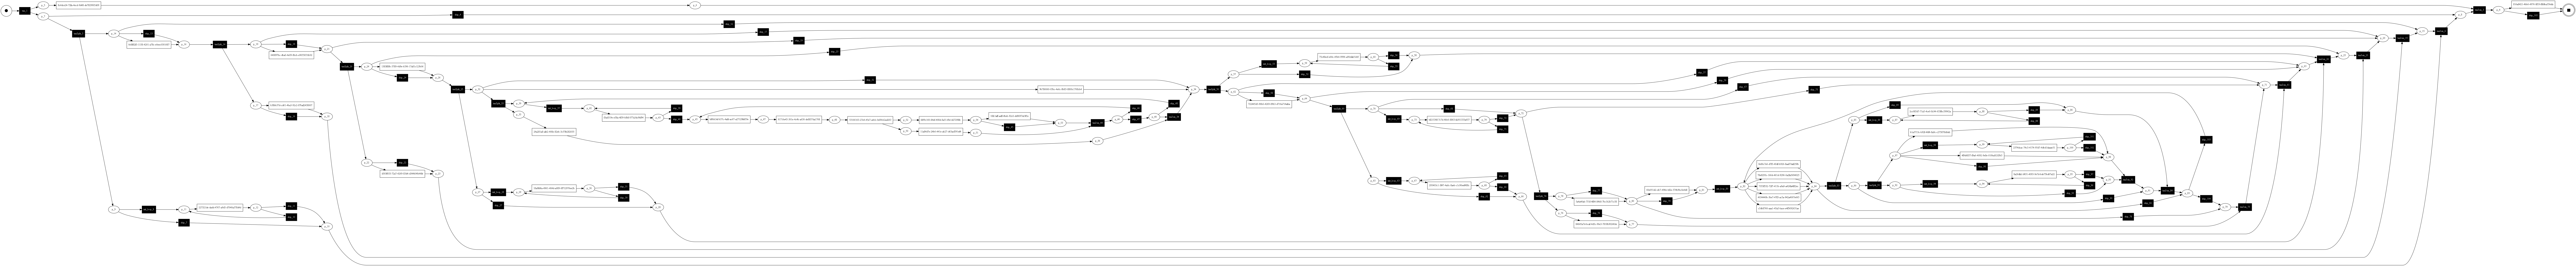

In [235]:
from pm4py.visualization.petri_net import visualizer

net, im, fm = pm4py.discover_petri_net_inductive(df_l)
gviz = visualizer.apply(net, im, fm, parameters={visualizer.Variants.WO_DECORATION.value.Parameters.DEBUG: True})
visualizer.view(gviz)

In [8]:
print(pm4py.llm.abstract_log_features(df_l))


 Given the following features:

Value 'sourceSystemID_0000' for Case Attribute 'Source':    number of non-zero values: 12000 ; quantiles of the non-zero: {0.0: 1.0, 0.25: 1.0, 0.5: 1.0, 0.75: 1.0, 1.0: 1.0}
Value 'Purchase order' for Case Attribute 'Purch. Doc. Category name':    number of non-zero values: 12000 ; quantiles of the non-zero: {0.0: 1.0, 0.25: 1.0, 0.5: 1.0, 0.75: 1.0, 1.0: 1.0}
Value 'Create Purchase Order Item' for Event Attribute 'concept:name':    number of non-zero values: 12000 ; quantiles of the non-zero: {0.0: 1.0, 0.25: 1.0, 0.5: 1.0, 0.75: 1.0, 1.0: 1.0}
Value 'companyID_0000' for Case Attribute 'Company':    number of non-zero values: 11950 ; quantiles of the non-zero: {0.0: 1.0, 0.25: 1.0, 0.5: 1.0, 0.75: 1.0, 1.0: 1.0}
Value 'Standard PO' for Case Attribute 'Document Type':    number of non-zero values: 11852 ; quantiles of the non-zero: {0.0: 1.0, 0.25: 1.0, 0.5: 1.0, 0.75: 1.0, 1.0: 1.0}
Values for Event Attribute 'Cumulative net worth (EUR)':    number of

In [9]:
print(pm4py.llm.abstract_variants(df_l))

If I have a process with the following process variants:

 Create Purchase Order Item -> Vendor creates invoice -> Record Goods Receipt -> Record Invoice Receipt -> Clear Invoice ( frequency = 2396  performance = 6154156.828 )
 Create Purchase Order Item -> Record Goods Receipt -> Vendor creates invoice -> Record Invoice Receipt -> Clear Invoice ( frequency = 1453  performance = 7279309.635 )
 Create Purchase Order Item -> Record Goods Receipt ( frequency = 583  performance = 2045744.048 )
 Create Purchase Order Item -> Vendor creates invoice -> Record Goods Receipt -> Record Invoice Receipt -> Remove Payment Block -> Clear Invoice ( frequency = 553  performance = 7842795.624 )
 Create Purchase Order Item -> Receive Order Confirmation -> Record Goods Receipt -> Vendor creates invoice -> Record Invoice Receipt -> Clear Invoice ( frequency = 484  performance = 8059432.190 )
 Create Purchase Order Item -> Vendor creates invoice -> Record Invoice Receipt -> Record Goods Receipt -> Remove P

In [16]:
df = pm4py.extract_temporal_features_dataframe(df_l, grouper_freq='D')
df

,timestamp,unique_resources,unique_cases,unique_activities,num_events,average_arrival_rate,average_finish_rate,average_waiting_time,average_sojourn_time,average_service_time
0,2001-02-19 00:00:00+00:00,1,1,1,1,0.000000,120.000000,5.570817e+08,5.570817e+08,0.0
1,2001-02-20 00:00:00+00:00,0,0,0,0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0
2,2001-02-21 00:00:00+00:00,0,0,0,0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0
3,2001-02-22 00:00:00+00:00,0,0,0,0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0
4,2001-02-23 00:00:00+00:00,0,0,0,0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...
6537,2019-01-13 00:00:00+00:00,0,0,0,0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0
6538,2019-01-14 00:00:00+00:00,29,89,8,107,151876.179775,2539.550562,5.639591e+06,5.639591e+06,0.0
6539,2019-01-15 00:00:00+00:00,24,57,11,73,3225.263158,1445.263158,5.922065e+06,5.922065e+06,0.0
6540,2019-01-16 00:00:00+00:00,26,106,8,112,129056.603774,998.490566,4.876667e+06,4.876667e+06,0.0


In [4]:
from pmxplain import abstract_aggregate

abstract_aggregate("""
Split: None (group_by) Group by case:Item Type
Fraction of total cases: 1%

Duration of the cases:

Column Display Name: Duration
Description: The duration of the case
Datatype: timedelta
Number of distinct values: 162
Function of the column in an event log: duration
Performance Statistics:
Average: 11w 4d 13:36:36
Median: 10w 6d 02:16:30


Columns that share the same property falues accross all cases:

Column Display Name: Item Category
Description:
Datatype: string
Number of distinct values: 1
Function of the column in an event log: None
Column Value for 100% of cases: 3-way match, invoice before GR

Column Display Name: Company
Description:
Datatype: string
Number of distinct values: 1
Function of the column in an event log: None
Column Value for 100% of cases: companyID_0000

Column Display Name: Goods Receipt
Description:
Datatype: bool
Number of distinct values: 1
Function of the column in an event log: None
Column Value for 100% of cases: True

Column Display Name: GR-Based Inv. Verif.
Description:
Datatype: bool
Number of distinct values: 1
Function of the column in an event log: None
Column Value for 100% of cases: False

Column Display Name: Service Time
Description: The service time of the case
Datatype: timedelta
Number of distinct values: 1
Function of the column in an event log: service_time
Column Value for 100% of cases: 0

Column Display Name: Item Type
Description:
Datatype: string
Number of distinct values: 1
Function of the column in an event log: None
Column Value for 100% of cases: Subcontracting

Column Display Name: Purch. Doc. Category name
Description:
Datatype: string
Number of distinct values: 1
Function of the column in an event log: None
Column Value for 100% of cases: Purchase order

Column Display Name: @@diff_start_end
Description:
Datatype: timedelta
Number of distinct values: 1
Function of the column in an event log: diff_start_end
Column Value for 100% of cases: 0

Column Display Name: Source
Description:
Datatype: string
Number of distinct values: 1
Function of the column in an event log: None
Column Value for 100% of cases: sourceSystemID_0000

Column Display Name: Document Type
Description:
Datatype: string
Number of distinct values: 1
Function of the column in an event log: None
Column Value for 100% of cases: Standard PO

""")

The group, making up 1% of total cases, uniformly corresponds to `Subcontracting` item type and falls under the `3-way match, invoice before GR` item category. Each case is associated with `companyID_0000`, carries out a goods receipt (`True`), lacks GR-based invoice verification (`False`), and has no service time (`0`). These cases are derived from `sourceSystemID_0000`, characterized by a `Standard PO` document type, and exhibit no start-end time difference (`0`). Cases have a varied average duration of `11w 4d 13:36:36`.


'The group, making up 1% of total cases, uniformly corresponds to `Subcontracting` item type and falls under the `3-way match, invoice before GR` item category. Each case is associated with `companyID_0000`, carries out a goods receipt (`True`), lacks GR-based invoice verification (`False`), and has no service time (`0`). These cases are derived from `sourceSystemID_0000`, characterized by a `Standard PO` document type, and exhibit no start-end time difference (`0`). Cases have a varied average duration of `11w 4d 13:36:36`.'